## Model Development & Performance

In [ ]:
import pandas as pd
import numpy as np
import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

from sklearn.ensemble import RandomForestRegressor
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import joblib

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.inspection import permutation_importance


import warnings
warnings.filterwarnings("ignore")

#### Data Loading

In [ ]:
df = pd.read_csv('../data/modelingData/modelingDataFrame.csv')

We will start with classic models to evaluate their effectiveness. As a first step, we will attempt to predict the number of people without power. Initially, we will remove columns that are not relevant to our task, such as time-related data and precise location identifiers (e.g., county name and code). The remaining data will be transformed and prepared for modeling.

### XGBRegressor

In [4]:
event_names = ['Astronomical Low Tide', 'Extreme Cold/Wind Chill', 'Flood','Winter Weather', 
               'Wildfire', 'Heavy Rain', 'Cold/Wind Chill', 'Dense Fog', 'Frost/Freeze', 'Strong Wind',
               'Lake-Effect Snow', 'Funnel Cloud', 'Flash Flood', 'Heavy Snow', 'Ice Storm', 
               'Thunderstorm Wind', 'Avalanche', 'Excessive Heat', 'Coastal Flood', 'Storm Surge/Tide', 
               'Sleet', 'Debris Flow', 'Winter Storm', 'Tropical Storm', 'Dust Storm', 'Drought', 
               'Blizzard', 'Lightning', 'Tornado', 'Hail', 'Rip Current', 'Heat', 'Freezing Fog', 
               'High Surf', 'High Wind',]

In [5]:
target = 'CustomersOut'

numeric_features = ['Tmin', 'Tmax', 'Tavg', 'Ppt', 'Lat', 'Lng']
categorical_features = ['Season', 'Region', 'Division']
event_features = [col for col in df.columns if col in event_names]

X = df[numeric_features + categorical_features + event_features]
y = df[target]

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

event_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('event', event_transformer, event_features)
])

In [8]:
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)

In [29]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    verbosity=1,
    colsample_bytree=0.3,
    early_stopping_rounds=20,
    random_state=42
)

xgb.fit(
    X_train_proc, y_train,
    eval_set=[(X_val_proc, y_val)],
    verbose=True
)

[0]	validation_0-rmse:1479.44628
[1]	validation_0-rmse:1478.76089
[2]	validation_0-rmse:1478.22730
[3]	validation_0-rmse:1477.31792
[4]	validation_0-rmse:1476.28734
[5]	validation_0-rmse:1476.25554
[6]	validation_0-rmse:1474.07049
[7]	validation_0-rmse:1473.13567
[8]	validation_0-rmse:1472.70791
[9]	validation_0-rmse:1472.28972
[10]	validation_0-rmse:1471.00776
[11]	validation_0-rmse:1470.85316
[12]	validation_0-rmse:1469.18733
[13]	validation_0-rmse:1468.38280
[14]	validation_0-rmse:1468.30442
[15]	validation_0-rmse:1467.59923
[16]	validation_0-rmse:1465.09802
[17]	validation_0-rmse:1464.53772
[18]	validation_0-rmse:1464.02536
[19]	validation_0-rmse:1463.91608
[20]	validation_0-rmse:1463.74474
[21]	validation_0-rmse:1463.73358
[22]	validation_0-rmse:1462.90520
[23]	validation_0-rmse:1461.81601
[24]	validation_0-rmse:1461.37282
[25]	validation_0-rmse:1461.28740
[26]	validation_0-rmse:1461.27876
[27]	validation_0-rmse:1461.05672
[28]	validation_0-rmse:1461.04833
[29]	validation_0-rmse:1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    verbosity=2
)

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.001, 0.5),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=1,
    random_state=42
)

random_search.fit(X_train_proc, y_train)

with open("random_search_results.pkl", "wb") as f:
    pickle.dump(random_search, f)

print("✅ Zapisano RandomizedSearchCV do pliku random_search_results.pkl")
print("✅ Najlepsze parametry:", random_search.best_params_)
print("📉 Najlepszy neg-RMSE (cross-val):", random_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.8123620356542087, learning_rate=0.4763571532049581, max_depth=5, n_estimators=171, subsample=0.8795975452591109; total time=  54.1s
[CV] END colsample_bytree=0.8123620356542087, learning_rate=0.4763571532049581, max_depth=5, n_estimators=171, subsample=0.8795975452591109; total time=  49.4s
[CV] END colsample_bytree=0.8123620356542087, learning_rate=0.4763571532049581, max_depth=5, n_estimators=171, subsample=0.8795975452591109; total time=  44.3s
[CV] END colsample_bytree=0.7468055921327309, learning_rate=0.07899726016810132, max_depth=5, n_estimators=187, subsample=0.8001125833417065; total time=  56.7s
[CV] END colsample_bytree=0.7468055921327309, learning_rate=0.07899726016810132, max_depth=5, n_estimators=187, subsample=0.8001125833417065; total time=  52.6s
[CV] END colsample_bytree=0.7468055921327309, learning_rate=0.07899726016810132, max_depth=5, n_estimators=187, subsample=0.8001125833417

In [15]:
best_model = random_search.best_estimator_
joblib.dump(best_model, "../models/xgb_model.pkl")
print("✅ Zapisano najlepszy model XGBoost do best_xgb_model.pkl")

✅ Zapisano najlepszy model XGBoost do best_xgb_model.pkl


In [19]:
y_pred = best_model.predict(X_val_proc)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 1414.8726
MAE: 91.6789
R²: 0.0882


#### Data Filtering Approach

Let's try this filtration method to refine the dataset. Rows where `ValidDataFlag == 1` are retained to ensure high-quality data. Event-related features with more than **99.8% zero values** are excluded, as they lack variance and would not contribute meaningful patterns to the model. Keeping only informative event features helps reduce unnecessary noise and enhances predictive performance. The final dataset consists of **numeric, categorical, and selected event features**, along with the target variable `CustomersOut`. To maintain robust model validation, we split the data into **80% training and 20% validation sets** using `train_test_split()` with `random_state=42` for consistency.


In [2]:
df = pd.read_csv('../data/modelingData/modelingDataFrame.csv')
event_names = ['Astronomical Low Tide', 'Extreme Cold/Wind Chill', 'Flood','Winter Weather', 
               'Wildfire', 'Heavy Rain', 'Cold/Wind Chill', 'Dense Fog', 'Frost/Freeze', 'Strong Wind',
               'Lake-Effect Snow', 'Funnel Cloud', 'Flash Flood', 'Heavy Snow', 'Ice Storm', 
               'Thunderstorm Wind', 'Avalanche', 'Excessive Heat', 'Coastal Flood', 'Storm Surge/Tide', 
               'Sleet', 'Debris Flow', 'Winter Storm', 'Tropical Storm', 'Dust Storm', 'Drought', 
               'Blizzard', 'Lightning', 'Tornado', 'Hail', 'Rip Current', 'Heat', 'Freezing Fog', 
               'High Surf', 'High Wind']

df = df[df['ValidDataFlag'] == 1]
df.shape
zero_percentages = {}

for col in event_names:
    if col in df.columns:
        zero_count = (df[col] == 0).sum()
        total_count = len(df)
        zero_percentage = (zero_count / total_count) * 100
        zero_percentages[col] = zero_percentage

zero_percentages_df = pd.DataFrame.from_dict(zero_percentages, orient='index', columns=['%_zero'])
zero_percentages_df = zero_percentages_df.sort_values('%_zero', ascending=False)

selected_events_name = [
    col for col, perc in zero_percentages.items() if perc < 99.8
]

target = 'CustomersOut'

numeric_features = ['Tmin', 'Tmax', 'Tavg', 'Ppt', 'Lat', 'Lng']
categorical_features = ['Season', 'Region', 'Division', 'StateName']
event_features = [col for col in df.columns if col in selected_events_name]

X = df[numeric_features + categorical_features + event_features]

y = df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

event_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('event', event_transformer, event_features)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Tmin', 'Tmax', 'Tavg',
                                                   'Ppt', 'Lat', 'Lng']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Season', 'Region',
                                                   'Division', 'StateName']),
                                                 ('event',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Flood', 'Winter Weather',
                                                   'Heavy Rain', 'Strong Wind',
                                                   'Flash Flood', 'Heavy Snow',
                                                   'Thunderstorm Wind',
                                                   'Excessive Heat',
                                                   'Winter Storm', 'Drought',
                                                   'Tornado', 'Hail', 'Heat',
                                                   'High Wind'])]))])

RMSE: 2124.4259
MAE: 169.20
R² score: 0.10


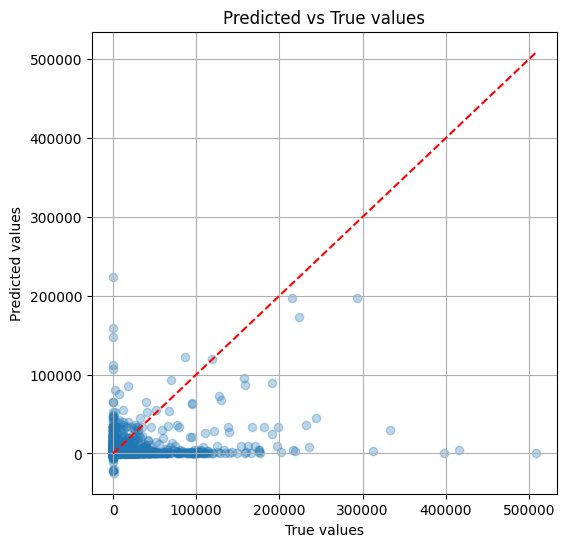

In [3]:
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
X_val_transformed = pipeline.named_steps['preprocessor'].transform(X_val)

model = XGBRegressor(n_estimators=100, verbosity=1)
model.fit(X_train_transformed, y_train)

y_pred = model.predict(X_val_transformed)

mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"RMSE: {rmse:.4f}")

print(f'MAE: {mae:.2f}')
print(f'R² score: {r2:.2f}')

plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--') 
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Predicted vs True values")
plt.grid(True)
plt.show()

Model `XGBRegressor(n_estimators=100)` is trained on the transformed dataset.
- **Performance:**
  - **RMSE:** 2124.43 (high error)
  - **MAE:** 169.20
  - **R²:** 0.10 (low predictive power)
- **Visualization:** Scatter plot shows predicted vs actual values, highlighting deviations.
- **Conclusion:** The model struggles with accuracy; further tuning and feature engineering could improve results.

Now we can check the results by state.

In [ ]:
states = df['StateName'].unique()
results = []

for state in states:
    df_state = df[df['StateName'] == state]
    X_state = df_state[numeric_features + categorical_features + event_features]
    y_state = df_state[target]

    X_state_transformed = pipeline.named_steps['preprocessor'].transform(X_state)

    y_pred_state = model.predict(X_state_transformed)

    rmse = np.sqrt(mean_squared_error(y_state, y_pred_state))
    mae = mean_absolute_error(y_state, y_pred_state)
    r2 = r2_score(y_state, y_pred_state)

    results.append({
        'State': state,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })

results_df = pd.DataFrame(results)

results_df = results_df.sort_values(by='RMSE')

print(results_df)


                           State          RMSE          MAE        R2
50                       Wyoming    112.344516    44.870771 -0.175773
48                  South Dakota    198.641250    63.850985 -0.132777
45                    New Mexico    259.696302    70.515635 -0.160683
42                       Montana    321.645758    95.524953 -0.026648
47                        Hawaii    346.119593   137.711690  0.040924
18                     Minnesota    368.410769    72.056583  0.192897
46                  North Dakota    392.241048   112.869028 -0.114985
33                       Vermont    423.060597   112.913620  0.130121
41                         Idaho    442.890654   106.757864 -0.015227
11                        Kansas    445.248450    72.726361  0.074060
35                 West Virginia    451.116370   113.067715  0.189418
5           District of Columbia    457.067022   104.278605  0.489351
4                       Delaware    466.637156   102.629262  0.045603
2                   

The model performs reasonably well in several states, with **Wyoming, South Dakota, and New Mexico** showing the lowest prediction errors. However, high **RMSE values in Puerto Rico and Florida** indicate significant inaccuracies, likely due to event variability. Many states have **RMSE below 1,000**, suggesting decent predictive accuracy overall, though **negative R² scores** in certain regions highlight areas needing improvement. Refining feature selection or tuning the model further could enhance performance in high-error states.

Now, we'll check if the model performs better when trained exclusively on a chosen state. By narrowing the dataset, we aim to improve predictive accuracy by focusing on **regional-specific patterns** rather than broader trends. We will use **`Season` and `CountyName`** as categorical columns to help capture local and seasonal influences.

In [ ]:
categorical_features = ['Season', 'CountyName']

states = df['StateName'].unique()

results = []

def get_top_features(model, feature_names, top_n=5):
    importance_dict = dict(zip(feature_names, model.feature_importances_))
    sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    return [f[0] for f in sorted_features[:top_n]]

for state in states:
    df_state = df[df['StateName'] == state]

    X = df_state[numeric_features + categorical_features + event_features]
    y = df_state[target]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    pipeline.fit(X_train, y_train)
    X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
    X_val_transformed = pipeline.named_steps['preprocessor'].transform(X_val)

    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()


    model =XGBRegressor(n_estimators=100, verbosity=1)
    model.fit(X_train_transformed, y_train)

    y_pred = model.predict(X_val_transformed)

    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    top_features = get_top_features(model, feature_names)

    results.append({
        'State': state,
        'MAE': mae,
        'R²': r2,
        'RMSE': rmse,
        'Top 1 Feature': top_features[0] if len(top_features) > 0 else None,
        'Top 2 Feature': top_features[1] if len(top_features) > 1 else None,
        'Top 3 Feature': top_features[2] if len(top_features) > 2 else None,
        'Top 4 Feature': top_features[3] if len(top_features) > 3 else None,
        'Top 5 Feature': top_features[4] if len(top_features) > 4 else None
    })

metrics_df = pd.DataFrame(results)
print(metrics_df)


                           State          MAE        R²          RMSE  \
0                       Arkansas    92.423410  0.078000    480.191664   
1                     California   362.748012 -0.058622   1589.475665   
2                       Colorado   114.179425  0.094870    815.553337   
3                    Connecticut   384.184886 -0.033213   3552.622081   
4                       Delaware    87.176364  0.315344    475.735834   
5           District of Columbia   131.720088  0.007563    758.615146   
6                        Florida   531.784652 -0.026152   6038.728641   
7                        Georgia    84.507718  0.323450    953.748630   
8                       Illinois    98.413732 -0.052797    802.880668   
9                        Indiana    95.810191  0.210965    450.431296   
10                          Iowa    84.157141 -0.216128   1115.290670   
11                        Kansas    67.573983  0.402866    478.081305   
12                      Kentucky    90.645549 -4.45

Comparing the model trained on **all states** to the one trained on **a single state**, we observe mixed results. The **all-states model shows lower RMSE** for high-error regions like **Puerto Rico (`RMSE = 13,321.12`) and Florida (`RMSE = 4,708.10`)**, suggesting that a broader dataset helps capture more diverse patterns. However, the **single-state model generally improves accuracy** in states with stronger localized trends, such as **Wyoming, South Dakota, and New Mexico**, which exhibit lower RMSE when trained individually. While **state-specific models may enhance regional precision**, the **all-state model remains beneficial for general predictions**, especially in areas with highly variable outage patterns. Further adjustments in feature selection or training strategies could optimize both approaches. 

Now, we'll check if the model performs better when trained exclusively on a chosen state. By narrowing the dataset, we aim to improve predictive accuracy by focusing on **regional-specific patterns** rather than broader trends. This time we will use **`Season` and `Month`** as categorical columns to help capture monthly and seasonal influences.

In [ ]:
categorical_features = ['Season', 'Month']
states = df['StateName'].unique()

results = []

def get_top_features(model, feature_names, top_n=5):
    importance_dict = dict(zip(feature_names, model.feature_importances_))
    sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    return [f[0] for f in sorted_features[:top_n]]

for state in states:
    df_state = df[df['StateName'] == state]

    X = df_state[numeric_features + categorical_features + event_features]
    y = df_state[target]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    pipeline.fit(X_train, y_train)
    X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
    X_val_transformed = pipeline.named_steps['preprocessor'].transform(X_val)

    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()


    model =XGBRegressor(n_estimators=100, verbosity=1)
    model.fit(X_train_transformed, y_train)

    y_pred = model.predict(X_val_transformed)

    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    top_features = get_top_features(model, feature_names)

    results.append({
        'State': state,
        'MAE': mae,
        'R²': r2,
        'RMSE': rmse,
        'Top 1 Feature': top_features[0] if len(top_features) > 0 else None,
        'Top 2 Feature': top_features[1] if len(top_features) > 1 else None,
        'Top 3 Feature': top_features[2] if len(top_features) > 2 else None,
        'Top 4 Feature': top_features[3] if len(top_features) > 3 else None,
        'Top 5 Feature': top_features[4] if len(top_features) > 4 else None
    })

# Przekształcenie wyników do DataFrame
metrics_df = pd.DataFrame(results)
print(metrics_df)


                           State          MAE        R²          RMSE  \
0                       Arkansas    90.118624  0.124034    468.050666   
1                     California   346.475520 -0.059088   1589.826090   
2                       Colorado   114.221992  0.100231    813.134552   
3                    Connecticut   388.967395  0.012866   3472.498657   
4                       Delaware    86.006387  0.347464    464.442254   
5           District of Columbia   131.974968  0.007355    758.694744   
6                        Florida   491.689648  0.089515   5688.218186   
7                        Georgia    81.773426  0.318867    956.973426   
8                       Illinois    98.084099 -0.708008   1022.641846   
9                        Indiana    93.981285  0.337007    412.890615   
10                          Iowa    85.150854 -0.090711   1056.217274   
11                        Kansas    64.564395  0.449964    458.840170   
12                      Kentucky    87.390614 -1.44

#### **Impact of Changing Categorical Features**

##### **Observed Changes**
1. **RMSE & Prediction Accuracy:**
   - Overall RMSE **decreased** for several states, suggesting improved predictions.
   - Florida saw a reduction from **6934 → 5688**, indicating better model performance.
   - Puerto Rico also showed slight improvement, from **13819 → 13398**.

2. **R² Score Improvements:**
   - Texas improved from **0.199 → 0.479**, suggesting better predictive fit.
   - Oregon improved significantly (**0.373 → 0.447**), likely benefiting from finer time granularity (`Month` instead of `CountyName`).

3. **Feature Importance Shifts:**
   - `Month` likely captured **seasonal trends more effectively** than `CountyName`, leading to better generalization.
   - States relying on local **county-based features** may have seen reduced influence from geographic-specific patterns.

##### **Conclusion**
Switching from **CountyName to Month** as a categorical feature appears to have enhanced **model performance**, particularly for **high-variance states**. This adjustment likely improved how the model accounts for **seasonal patterns and temporal dependencies**, rather than relying on **geographic locality**, leading to better predictive power. 🚀


### XGBRegressor Conclusion
Due to the **high complexity and noise** in the data, the model struggled to accurately estimate target values. While **state-specific models improved performance in certain regions**, high-error areas like **Puerto Rico and Florida** continued to show significant prediction challenges. The **all-states model demonstrated better generalization**, reducing RMSE for some states, but **negative R² values indicate areas that require further refinement**. Next, we will explore different modeling approaches to enhance predictive accuracy.

### MLPRegressor

For the MLP model, we apply **similar data filtration** to what was used in **XGBRegressor**, excluding `StateName` from categorical features. This process includes filtering rows where `ValidDataFlag == 1` to ensure high-quality data and removing event-related features with more than **99.8% zero values** to minimize noise and improve model performance.

In [ ]:
df = pd.read_csv('../data/modelingData/modelingDataFrame.csv')
event_names = ['Astronomical Low Tide', 'Extreme Cold/Wind Chill', 'Flood','Winter Weather', 
               'Wildfire', 'Heavy Rain', 'Cold/Wind Chill', 'Dense Fog', 'Frost/Freeze', 'Strong Wind',
               'Lake-Effect Snow', 'Funnel Cloud', 'Flash Flood', 'Heavy Snow', 'Ice Storm', 
               'Thunderstorm Wind', 'Avalanche', 'Excessive Heat', 'Coastal Flood', 'Storm Surge/Tide', 
               'Sleet', 'Debris Flow', 'Winter Storm', 'Tropical Storm', 'Dust Storm', 'Drought', 
               'Blizzard', 'Lightning', 'Tornado', 'Hail', 'Rip Current', 'Heat', 'Freezing Fog', 
               'High Surf', 'High Wind']

df = df[df['ValidDataFlag'] == 1]
df.shape
zero_percentages = {}

for col in event_names:
    if col in df.columns:
        zero_count = (df[col] == 0).sum()
        total_count = len(df)
        zero_percentage = (zero_count / total_count) * 100
        zero_percentages[col] = zero_percentage

zero_percentages_df = pd.DataFrame.from_dict(zero_percentages, orient='index', columns=['%_zero'])
zero_percentages_df = zero_percentages_df.sort_values('%_zero', ascending=False)


selected_events_name = [
    col for col, perc in zero_percentages.items() if perc < 99.8
]

target = 'CustomersOut'

numeric_features = ['Tmin', 'Tmax', 'Tavg', 'Ppt', 'Lat', 'Lng']
categorical_features = ['Season', 'Region', 'Division']
event_features = [col for col in df.columns if col in selected_events_name]

X = df[numeric_features + categorical_features + event_features]

y = df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

event_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('event', event_transformer, event_features)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

pipeline.fit(X_train, y_train)

Iteration 1, loss = 2358331.04016525
Iteration 2, loss = 2342723.85430777
Iteration 3, loss = 2326854.12238061
Iteration 4, loss = 2329904.31733197
Iteration 5, loss = 2323529.97013589
Iteration 6, loss = 2311010.15579568
Iteration 7, loss = 2303869.49520276
Iteration 8, loss = 2296051.28910947
Iteration 9, loss = 2290846.91342595
Iteration 10, loss = 2287674.86490510
Iteration 11, loss = 2287246.53746495
Iteration 12, loss = 2283987.21219515
Iteration 13, loss = 2275199.02708899
Iteration 14, loss = 2266657.73272767
Iteration 15, loss = 2256320.16536253
Iteration 16, loss = 2276097.22890867
Iteration 17, loss = 2265881.65139189
Iteration 18, loss = 2266084.65438891
Iteration 19, loss = 2266390.40786770
Iteration 20, loss = 2255112.37917947
Iteration 21, loss = 2262840.79317302
Iteration 22, loss = 2259646.42091919
Iteration 23, loss = 2250510.64734633
Iteration 24, loss = 2264694.58121693
Iteration 25, loss = 2256937.45467701
Iteration 26, loss = 2250525.39477033
Iteration 27, loss = 

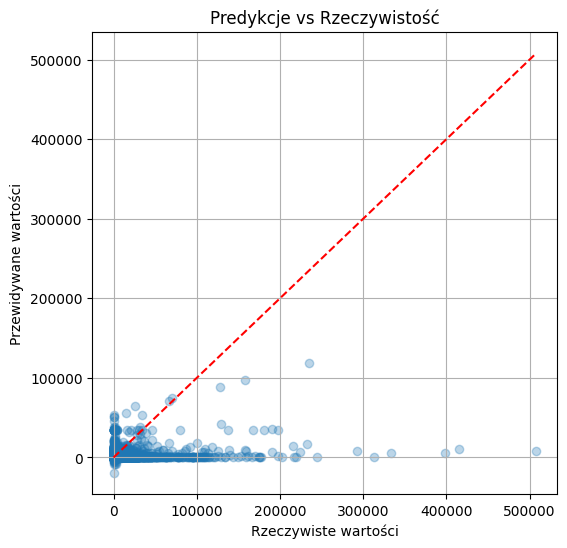

In [ ]:
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
X_val_transformed = pipeline.named_steps['preprocessor'].transform(X_val)

model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=100, activation='relu', random_state=42, verbose=True,learning_rate_init=0.01)
model.fit(X_train_transformed, y_train)

joblib.dump(model, '../models/model_MLP.pkl')

y_pred = model.predict(X_val_transformed)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))


print(f"RMSE: {rmse:.4f}")

print(f'MAE: {mae:.2f}')
print(f'R² score: {r2:.2f}')

plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--') 
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Predicted vs True values")
plt.grid(True)
plt.show()



Model: `MLPRegressor(hidden_layer_sizes=(100, 50),activation='relu')` was trained on the transformed dataset.
- **Performance:**
  - **RMSE:** 2158.91 (high error)
  - **MAE:** 174.67
  - **R²:** 0.07 (low predictive power)
- **Conclusion:** The model struggles with accuracy; further tuning and adjustments to neural network parameters could improve results. 

Now we can compare results by states.

In [ ]:
states = df['StateName'].unique()
results = []

for state in states:
    df_state = df[df['StateName'] == state]
    X_state = df_state[numeric_features + categorical_features + event_features]
    y_state = df_state[target]

    X_state_transformed = pipeline.named_steps['preprocessor'].transform(X_state)

    y_pred_state = model.predict(X_state_transformed)

    rmse = np.sqrt(mean_squared_error(y_state, y_pred_state))
    mae = mean_absolute_error(y_state, y_pred_state)
    r2 = r2_score(y_state, y_pred_state)

    results.append({
        'State': state,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })

results_df = pd.DataFrame(results)

results_df = results_df.sort_values(by='RMSE')

print(results_df)

                           State          RMSE          MAE         R2
50                       Wyoming    124.096248    74.698393  -0.434620
48                  South Dakota    190.441293    61.580602  -0.041185
45                    New Mexico    243.248698    69.397601  -0.018317
42                       Montana    316.462860    88.376555   0.006171
47                        Hawaii    366.919246   152.358287  -0.077809
46                  North Dakota    372.496182    90.242784  -0.005557
18                     Minnesota    403.811172    78.842081   0.030337
41                         Idaho    440.309340    95.569429  -0.003428
11                        Kansas    457.153105    73.427817   0.023884
4                       Delaware    474.389109   102.630366   0.013630
39                        Alaska    480.989941   158.682870  -0.019036
35                 West Virginia    512.835072   133.258490  -0.047550
33                       Vermont    517.866990   174.231526  -0.303438
44    

### MLPRegressor Conclusion
The **MLP model struggled to achieve strong predictive accuracy**, with an overall **RMSE of 2158.91** and a low **R² of 0.07**, indicating weak explanatory power. Across individual states, RMSE values varied, but most regions experienced **significant errors**, particularly **Puerto Rico (`RMSE = 13,574.98`) and Florida (`RMSE = 6,205.43`)**. Many states also had **negative R² scores**, highlighting poor model fit. While some states, such as **North Carolina (`R² = 0.23`) and Texas (`R² = 0.07`)**, showed moderate predictive strength, the overall model performance remains **limited**, suggesting the need for **alternative modeling approaches or further tuning**.

### Comparison: MLP vs. XGBRegressor

##### 1. Performance Overview
- **XGBRegressor** consistently outperformed **MLP**, achieving lower RMSE and higher R² scores across most states.
- **MLP struggled** with high errors, demonstrating weak predictive power (**R² ≈ 0.07**), while **XGBRegressor** showed better generalization (**R² varied but was generally higher**).
- In high-error states like **Puerto Rico and Florida**, **XGB had lower RMSE**, indicating better adaptability to complex patterns.

##### 2. Model Strengths
| Feature | **MLP** | **XGBRegressor** |
|---------|--------|--------------|
| **Handling Complexity** | Struggles with noisy data | Handles high-dimensional, noisy data well |
| **Training Speed** | Slower due to backpropagation | Faster with efficient gradient boosting |
| **Interpretability** | Less transparent | Easier to interpret feature importance |
| **Generalization** | Limited across states | Stronger across diverse regions |

##### 3. Key Takeaways
- **XGBRegressor is superior** for modeling outage prediction across states due to better handling of noisy data and interpretability.
- **MLP may require further tuning** or alternative architectures to improve accuracy.
- Moving forward, **advanced optimization techniques** or hybrid models could be explored to enhance predictive performance. 🚀


### Time Series Modelling

Another model we are testing is the SARIMAX model, which is used for time series forecasting. It is particularly important as it allows us to account for both seasonal effects and exogenous variables. Since our data is aggregated on a daily basis, we can evaluate how well this model performs with such a frequency.

This model takes time as an input, but time is not unique in our dataset, since we are analyzing power outages separately for each county—this means that the same dates appear multiple times. The idea is to group dataset by county and analyse it separately.

The predicted variable will be PercentCustomersOut, which represents the number of people without power divided by the total population in the county. This metric better reflects differences between counties, as one county may be significantly larger than others.

In [ ]:
df = pd.read_csv('../data/modelingData/modelingDataFrame.csv')

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df[~df['Date'].dt.year.isin([2014, 2015, 2016, 2017, 2018])]
data_splits = {}
grouped = df.groupby(['StateName', 'CountyName'])

We will split the DataFrame into training and testing sets. Since our goal is to make early predictions, we will use the most recent year (i.e., the last 365 days) as the test set.

In [ ]:
for (state, county), group in grouped:
    group = group.sort_values('Date').reset_index(drop=True)
    
    if len(group) > 1600:
        df_train = group.iloc[:-365]
        df_test = group.iloc[-365:]
    else:
        pass
    
    key = f"{state}_{county}"
    data_splits[key] = [df_train, df_test]

We are now transforming or removing the following columns:

- FIPS, Month, Year, Region, Division, lng_rad, lat_rad, StateName, CountyName – these columns contain only one unique value per county and therefore do not add value for modeling.

- Month and Year – these will be removed since we will use the date column to model seasonality.

- ValidDataFlag 


The following transformations will be applied:

- season – this is a categorical variable and will be one-hot encoded into binary features.

Finally, we will sort the data by the date column and set it as the index of the DataFrame.

In [ ]:
for key, (df_train, df_test) in data_splits.items():

    col_to_stay = ['Date', 'CountyName', 
                      'StateName', 'PercentCustomersOut', 'Season', 'Tmin',
       'Tmax', 'Tavg', 'Ppt',  'Flood', 'Winter Weather', 'Heavy Rain', 'Strong Wind', 'Flash Flood', 'Heavy Snow', 'Thunderstorm Wind', 'Excessive Heat', 'Winter Storm', 'Drought', 'Tornado', 'Hail', 'Heat', 'High Wind']
    if not df_train.empty:
        df_train = df_train[[col for col in col_to_stay if col in df_train.columns]]
        
        df_train = pd.get_dummies(df_train, columns=['Season'])
        df_train['Date'] = pd.to_datetime(df_train['Date'], errors='coerce')
        df_train = df_train.sort_values('Date')
        df_train.set_index('Date', inplace=True)
        df_train = df_train.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

    if not df_test.empty:
        df_test = df_test[[col for col in col_to_stay if col in df_test.columns]]
        
        df_test = pd.get_dummies(df_test, columns=['Season'])
        df_test['Date'] = pd.to_datetime(df_test['Date'], errors='coerce')
        df_test = df_test.sort_values('Date')
        df_test.set_index('Date', inplace=True)
        df_test = df_test.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

    data_splits[key] = [df_train, df_test]


Since we have two possible target columns (PercentCustomersOut and CustomersOut), we will compare the results obtained using each of them to evaluate which one yields better performance.

In [ ]:
dict_percent_customers_out = copy.deepcopy(data_splits)

The Augmented Dickey-Fuller (ADF) Test is a statistical test used to determine whether a time series is stationary or not. A stationary series has constant statistical properties such as mean, variance, and autocorrelation over time. The ADF test works by testing the null hypothesis that a unit root is present in the time series, which would imply the series is non-stationary (i.e., it has a trend or random walk behavior). If the test statistic is significantly negative and the p-value is low (usually less than 0.05), we reject the null hypothesis and conclude that the series is stationary.

In [ ]:
non_stationary_keys = []
constant_keys = []

all_keys = list(dict_percent_customers_out.keys())

for idx, (key, d) in enumerate(dict_percent_customers_out.items()):
    series = d[1]['PercentCustomersOut']
    
    if series.nunique() == 1:
        print(f"{key} has constant values. Skipping ADF test.")
        constant_keys.append(key)
        continue
    
    result = adfuller(series)
    if idx < 2:
        print('ADF Statistic for ' + key + ': ' + str(result[0]))
        print('p-value for ' + key + ': ' + str(result[1]))
        print('------------------------------------------------')

    p_value = result[1]
    if p_value > 0.05:
        print(f'{key} is NOT stationary!')
        non_stationary_keys.append(key)

if not non_stationary_keys:
    print('All non-constant counties are stationary!')
else:
    print('Counties that are not stationary:', non_stationary_keys)

if constant_keys:
    print('Counties with constant PercentCustomersOut:', constant_keys)


ADF Statistic for Alabama_Autauga: -13.574866367245829
p-value for Alabama_Autauga: 2.1793846437174594e-25
------------------------------------------------
ADF Statistic for Alabama_Baldwin: -14.528043728451822
p-value for Alabama_Baldwin: 5.388024435398192e-27
------------------------------------------------
Arkansas_Jefferson is NOT stationary!
California_Trinity has constant values. Skipping ADF test.
Colorado_Morgan is NOT stationary!
Colorado_Weld is NOT stationary!
Georgia_Terrell is NOT stationary!
Illinois_Jefferson is NOT stationary!
Maine_Franklin is NOT stationary!
Maine_Kennebec is NOT stationary!
Maine_Oxford is NOT stationary!
Missouri_Atchison is NOT stationary!
Missouri_Boone is NOT stationary!
Missouri_Stone is NOT stationary!
Missouri_Sullivan is NOT stationary!
Missouri_Washington is NOT stationary!
New Hampshire_Carroll is NOT stationary!
North Carolina_Graham has constant values. Skipping ADF test.
North Carolina_Haywood has constant values. Skipping ADF test.
Nort

In [ ]:
for key in non_stationary_keys:
    if key in dict_percent_customers_out and len(dict_percent_customers_out[key]) > 1:
        df = dict_percent_customers_out[key][1]

        diff_series = df['PercentCustomersOut'].diff()
        df = df.iloc[1:, :].copy()
        df['PercentCustomersOut'] = diff_series.dropna()

        dict_percent_customers_out[key][1] = df


#### Interpretation:

If p-values are smaller than 0.05, it means that for each of these counties, we can reject the null hypothesis of non-stationarity in the time series. Practically, this indicates that the data is stationary and can be used for analysis, modeling, and forecasting without the need for additional transformations such as removing trends or seasonality.



- Almost all values of the ADF test statistics are negative, indicating that we can confidently reject the null hypothesis of non-stationarity for most counties. For the few counties that were initially non-stationary, we applied differencing to transform them into stationary series. As a result, all time series are now stationary, with no significant trend or unit root present.

### ACF and PACF Plots

**Purpose:**
- **ACF (Autocorrelation Function)** and **PACF (Partial Autocorrelation Function)** plots are used to analyze the autocorrelations in a time series.
- ACF measures the correlation between a time series and its lagged values over different periods.
- PACF shows the partial correlation, which measures the correlation between the series and its lag, after removing the effects of shorter lags.

- **ACF Plot:** If the ACF shows a sharp cutoff, it suggests an MA process of a certain order.
- **PACF Plot:** A sharp cutoff in the PACF plot indicates the order of the AR component.


In [ ]:
import random

def plot_acf_pacf_random(dict_data, lag, col='PercentCustomersOut', n_samples=5):
    plt.figure(figsize=(14, 10))
    
    sampled_keys = random.sample(list(dict_data.keys()), n_samples)

    for i, key in enumerate(sampled_keys, 1):
        d = dict_data[key]
        train = d[1]

        plt.subplot(n_samples, 2, 2 * i - 1)
        plot_acf(train[col], lags=lag, ax=plt.gca())
        plt.title(f"ACF - {key}")

        plt.subplot(n_samples, 2, 2 * i)
        plot_pacf(train[col], lags=lag, ax=plt.gca(), method='ywm')
        plt.title(f"PACF - {key}")

    plt.tight_layout()
    plt.show()

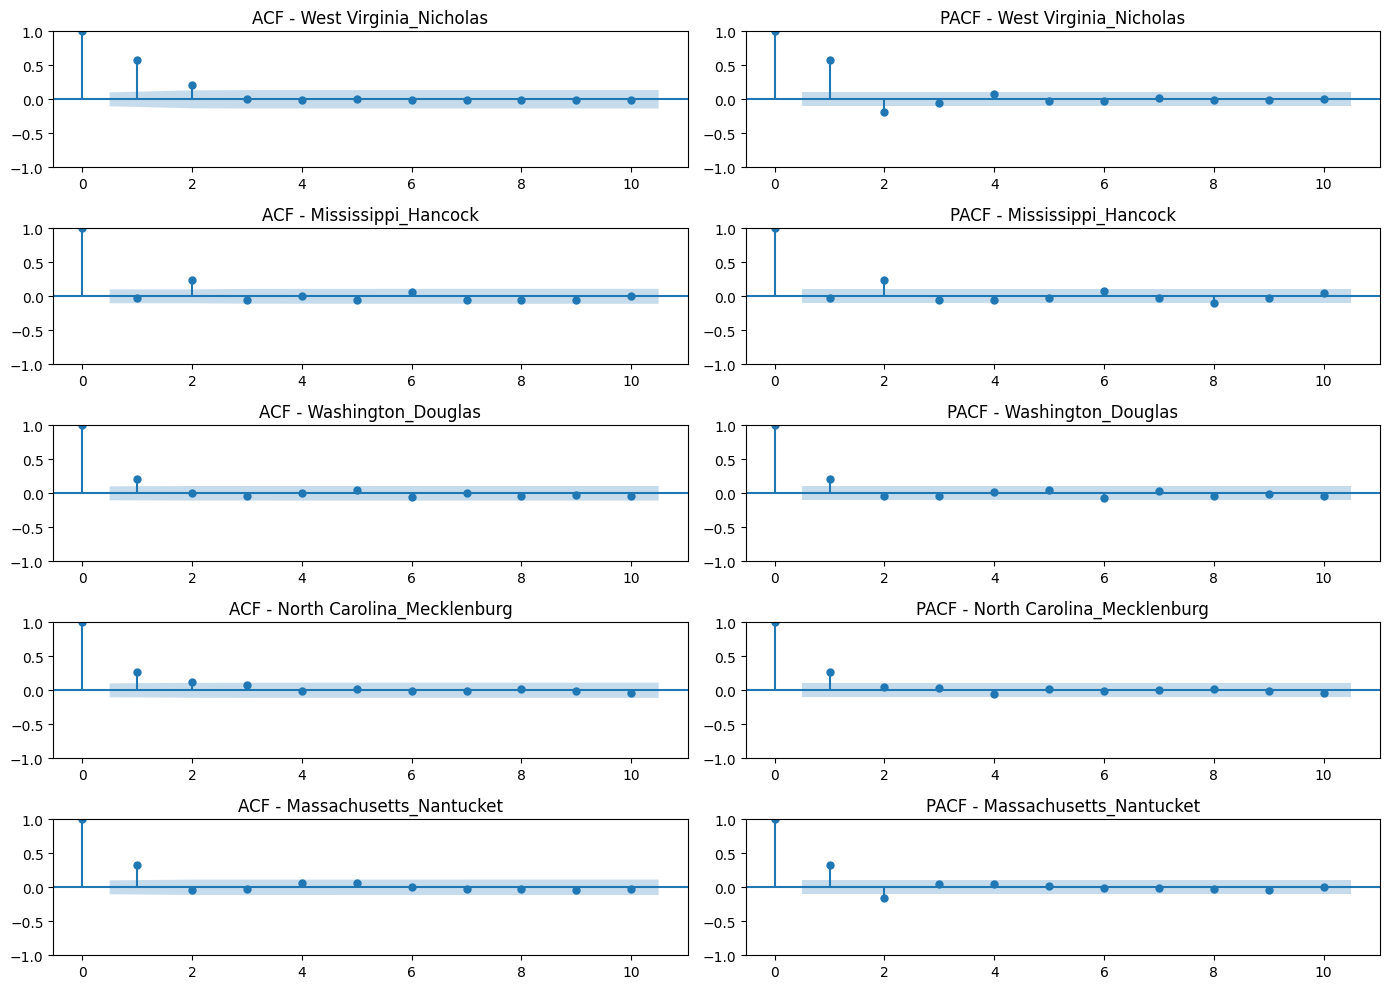

In [ ]:
plot_acf_pacf_random(dict_percent_customers_out, 10)

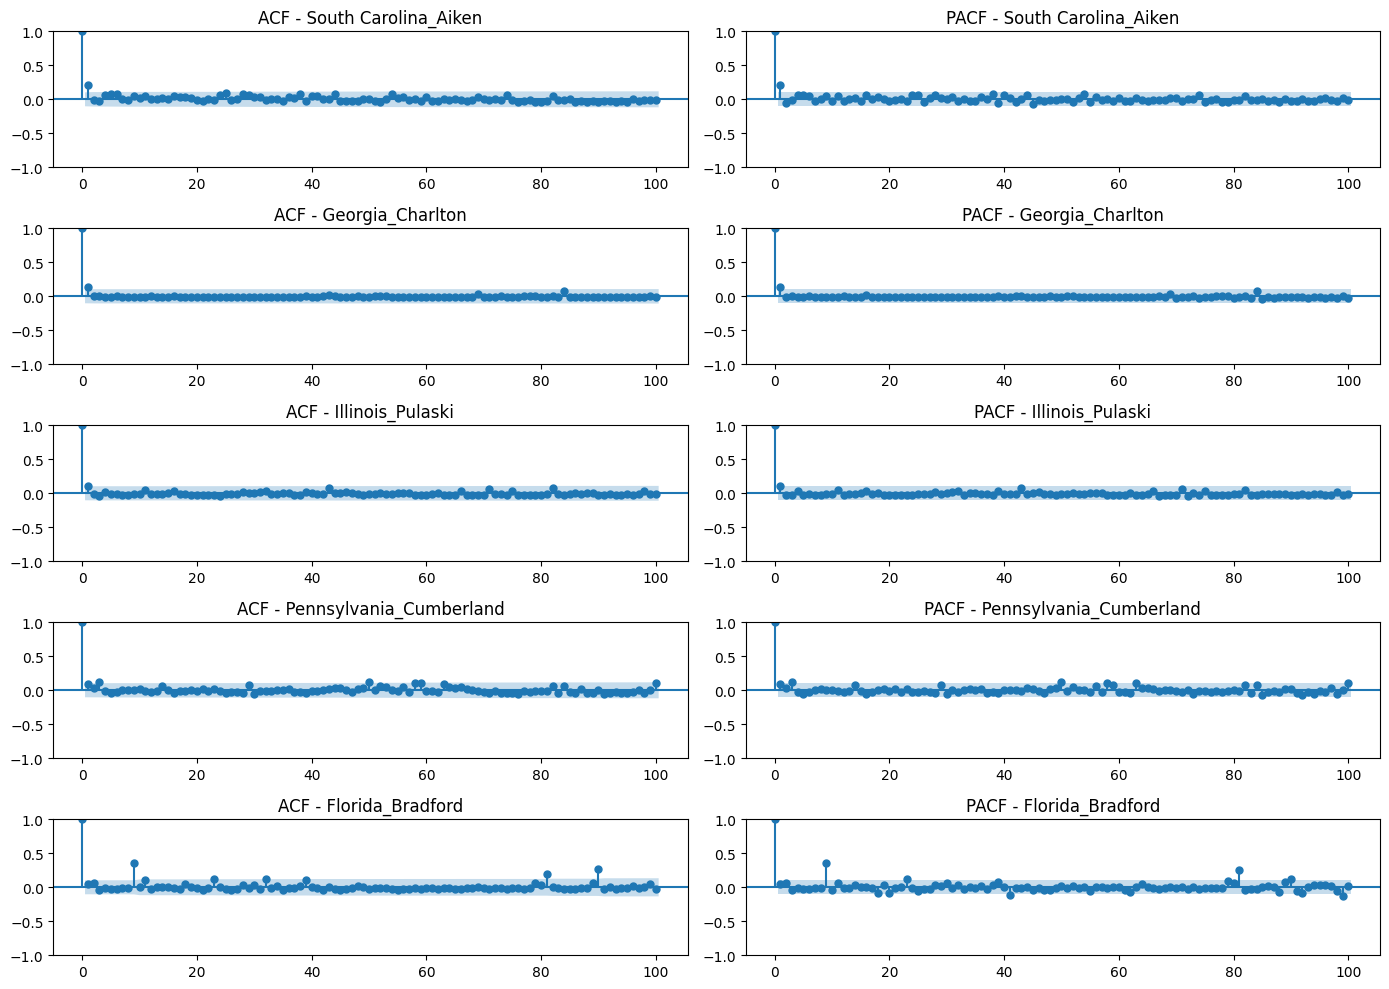

In [ ]:
plot_acf_pacf_random(dict_percent_customers_out, 100)

- In this case, for all counties, the ACF plots show a sharp drop after a few lags. This suggests that most of the correlation in the series is captured by the initial few lags. After that, the correlation quickly diminishes, indicating short-range dependence
- the series has little memory
- PACF has a significant peak at lag 1, suggesting that an AR(1) process might also be a reasonable starting point for these counties

In [ ]:
q = 1
p = 1
dd = 0

#### models

In [ ]:
dict_copy = copy.deepcopy(dict_percent_customers_out)

In [ ]:
for key, (train, test) in dict_copy.items():
    cols_to_remove = ['StateName', 'CountyName']

    train = train.drop(columns=cols_to_remove, errors='ignore')
    test = test.drop(columns=cols_to_remove, errors='ignore')
    dict_copy[key] = [train, test]


In [ ]:
for key, d in dict_copy.items():
    try:
        train = d[0]
        test = d[1]

        train = train[~train.index.duplicated()]
        test = test[~test.index.duplicated()]

        train.index = pd.to_datetime(train.index)
        test.index = pd.to_datetime(test.index)

        print(f"Last date in training for {key}: {train.index[-1]}")

        model = SARIMAX(
            train['PercentCustomersOut'],
            exog=train.drop(columns='PercentCustomersOut'),
            order=(p, dd, q), 
            seasonal_order=(0, 0, 0, 0),
            enforce_stationarity=False,
            enforce_invertibility=False
        )

        results = model.fit(disp=False)

        n_test = len(test)
        forecast_results = results.get_forecast(steps=n_test, exog=test.drop(columns='PercentCustomersOut'))

        forecast = forecast_results.predicted_mean

        dict_copy[key].append(results)
        dict_copy[key].append(forecast)
        
    except Exception as e:
        print(f"Error processing {key}: {e}")
        continue

Last date in training for Alabama_Autauga: 2022-12-31 00:00:00
Last date in training for Alabama_Baldwin: 2023-01-01 00:00:00
Last date in training for Alabama_Barbour: 2022-12-31 00:00:00
Last date in training for Alabama_Bibb: 2023-01-01 00:00:00
Last date in training for Alabama_Blount: 2023-01-04 00:00:00
Last date in training for Alabama_Bullock: 2022-12-31 00:00:00
Last date in training for Alabama_Butler: 2023-02-01 00:00:00
Last date in training for Alabama_Calhoun: 2023-02-02 00:00:00
Last date in training for Alabama_Chambers: 2022-12-31 00:00:00
Last date in training for Alabama_Chilton: 2022-12-31 00:00:00
Last date in training for Alabama_Choctaw: 2023-01-03 00:00:00
Last date in training for Alabama_Clarke: 2023-01-11 00:00:00
Last date in training for Alabama_Clay: 2023-03-15 00:00:00
Last date in training for Alabama_Cleburne: 2023-01-01 00:00:00
Last date in training for Alabama_Coffee: 2023-01-08 00:00:00
Last date in training for Alabama_Conecuh: 2023-01-08 00:00:00


Now it it time for evaluating those models and compare them between counties. We will use rmse and mae metrics

In [ ]:
results = {}
for key, d in dict_copy.items():
    if len(d) == 4:
        try:
            if len(d) == 4:
                test = d[1]
                forecast = d[3]
                test = test[~test.index.duplicated()]
                y_true = test.loc[forecast.index, 'PercentCustomersOut']

                mae = mean_absolute_error(y_true, forecast)
                rmse = np.sqrt(mean_squared_error(y_true, forecast))

                results[key] = [mae, rmse]
        except Exception as e:
            continue



In [ ]:
df = pd.DataFrame([(key, *values) for key, values in results.items()], columns=['state_county', 'mae', 'rmse'])

In [ ]:
mean_mae = df['mae'].mean()
mean_rmse = df['rmse'].mean()
print(mean_mae)
print(mean_rmse)

0.4557769041474929
1.385898658838184


Let's see which counties have the best and the worst values:

In [ ]:
df.sort_values('mae')

,state_county,mae,rmse
1743,North Carolina_Swain,0.000000,0.000000
1701,North Carolina_Haywood,0.000000,0.000000
1712,North Carolina_Macon,0.000000,0.000000
1744,North Carolina_Transylvania,0.000000,0.000000
1695,North Carolina_Graham,0.000000,0.000000
...,...,...,...
1658,North Carolina_Alamance,6.199641,11.847988
2423,Texas_Presidio,7.819586,18.755436
2359,Texas_Jeff davis,10.338505,20.826480
1702,North Carolina_Henderson,33.680730,37.863865


Counties with very low metrics are counties where in training data there was no major power outages. models predicted 0 all the time and it was correct, but it does not mean that the model is working well. Due to lack of sifficient data in those couties we will skip them

In [ ]:
df = df[df['mae'] > 0.1]

In [ ]:
counties_to_visualise = np.array(df.sort_values('rmse').head(10)[['state_county']])

Let's visualise the counties with low rmse:

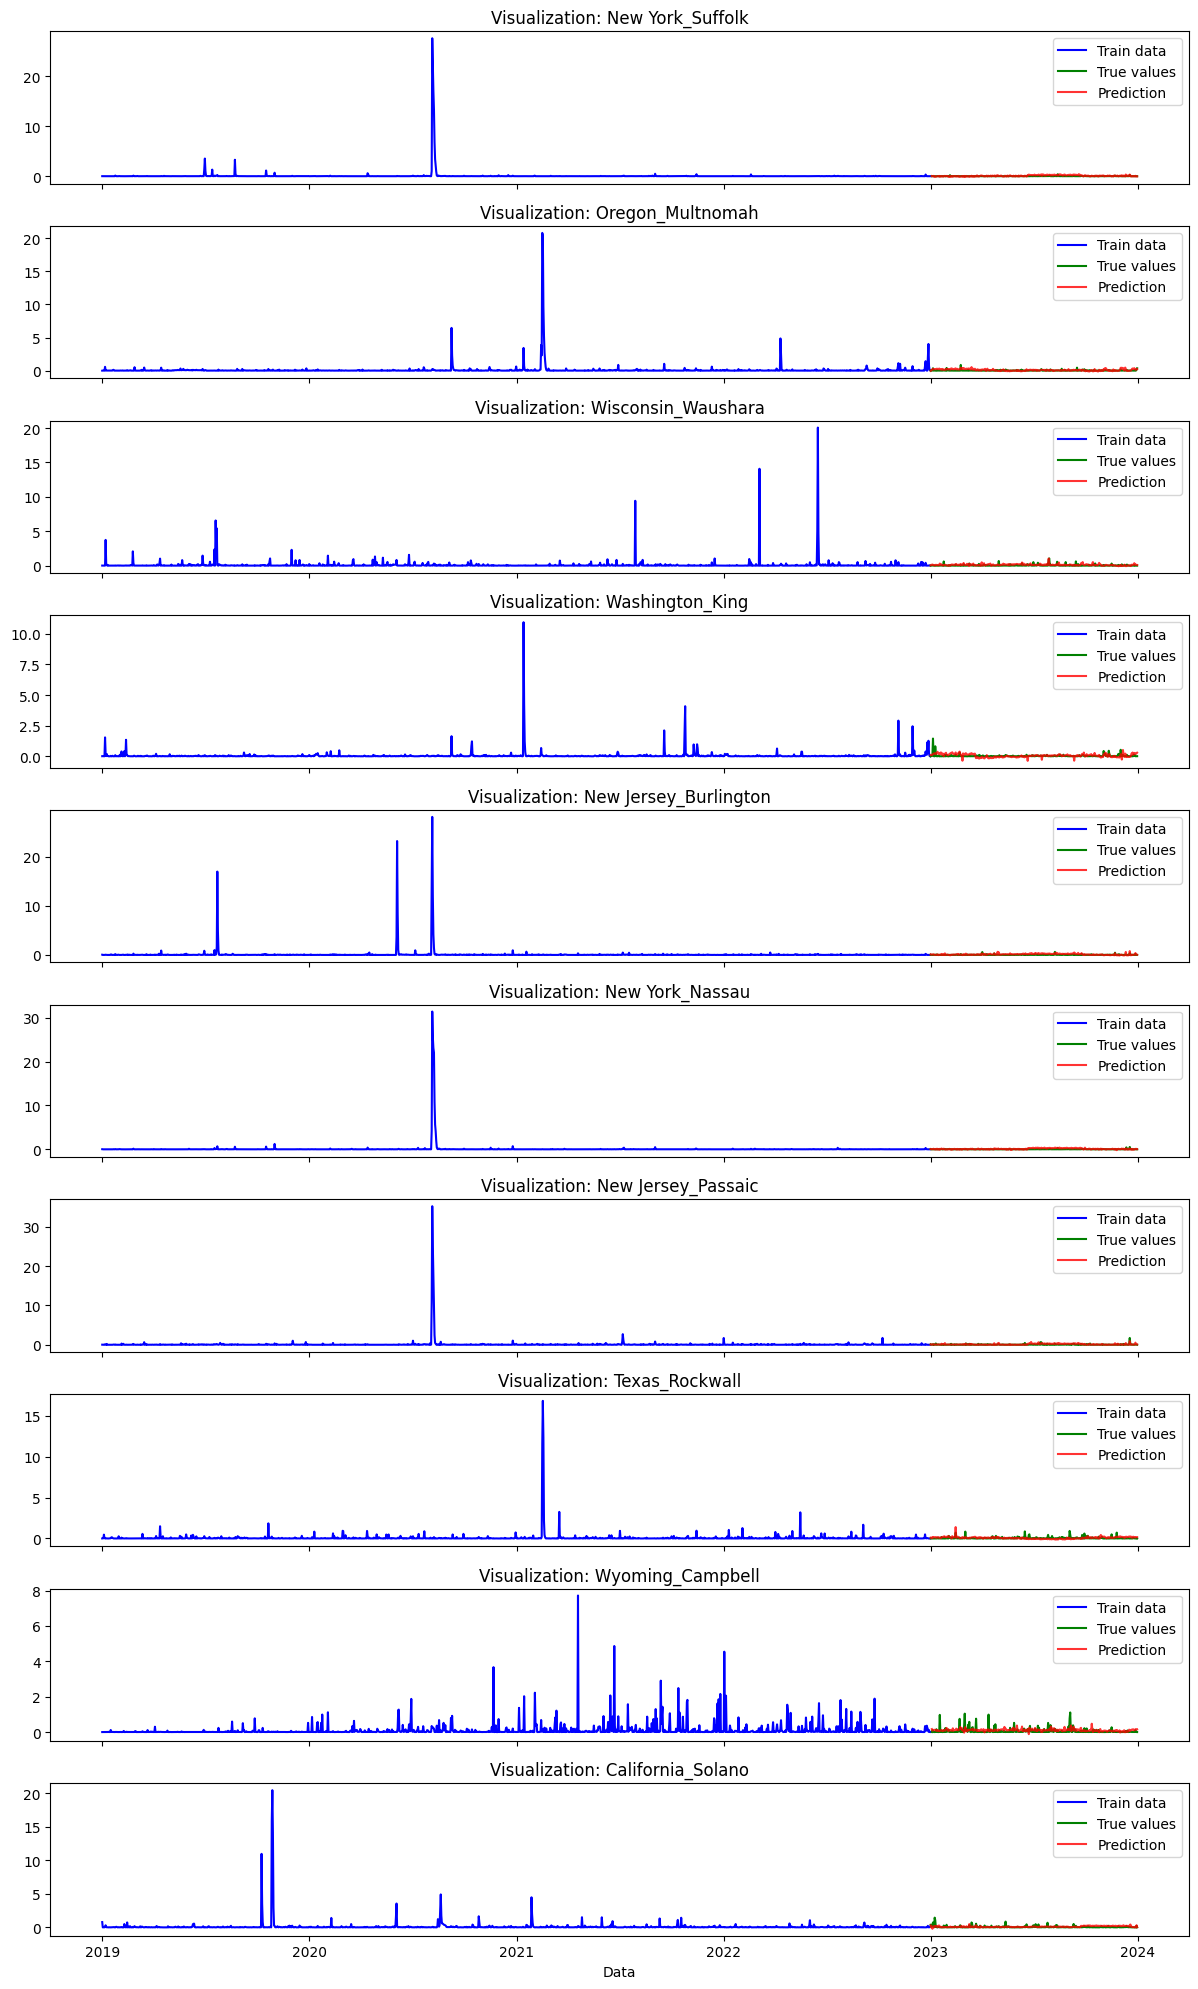

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 20), sharex=True)
fig.subplots_adjust(hspace=0.4)

for ax, county in zip(axes, counties_to_visualise):

    row = dict_copy[county[0]]
    train = row[0]
    test = row[1]
    forecast = row[3]

    train = train[~train.index.duplicated()]
    test = test[~test.index.duplicated()]
        
    ax.plot(train.index, train['PercentCustomersOut'], label='Train data', color='blue')
    ax.plot(test.index, test['PercentCustomersOut'], label='True values', color='green')
    ax.plot(test.index, forecast, label='Prediction', color='red', alpha=0.8)
    ax.set_title(f'Visualization: {county[0]}')
    #ax.set_ylim(0, maxlim)
    ax.legend()

    plt.xlabel("Data")
plt.tight_layout()
plt.show()

And counties with the highest rmse:

In [ ]:
counties_to_visualise = np.array(df.sort_values('rmse').tail(10)[['state_county']])

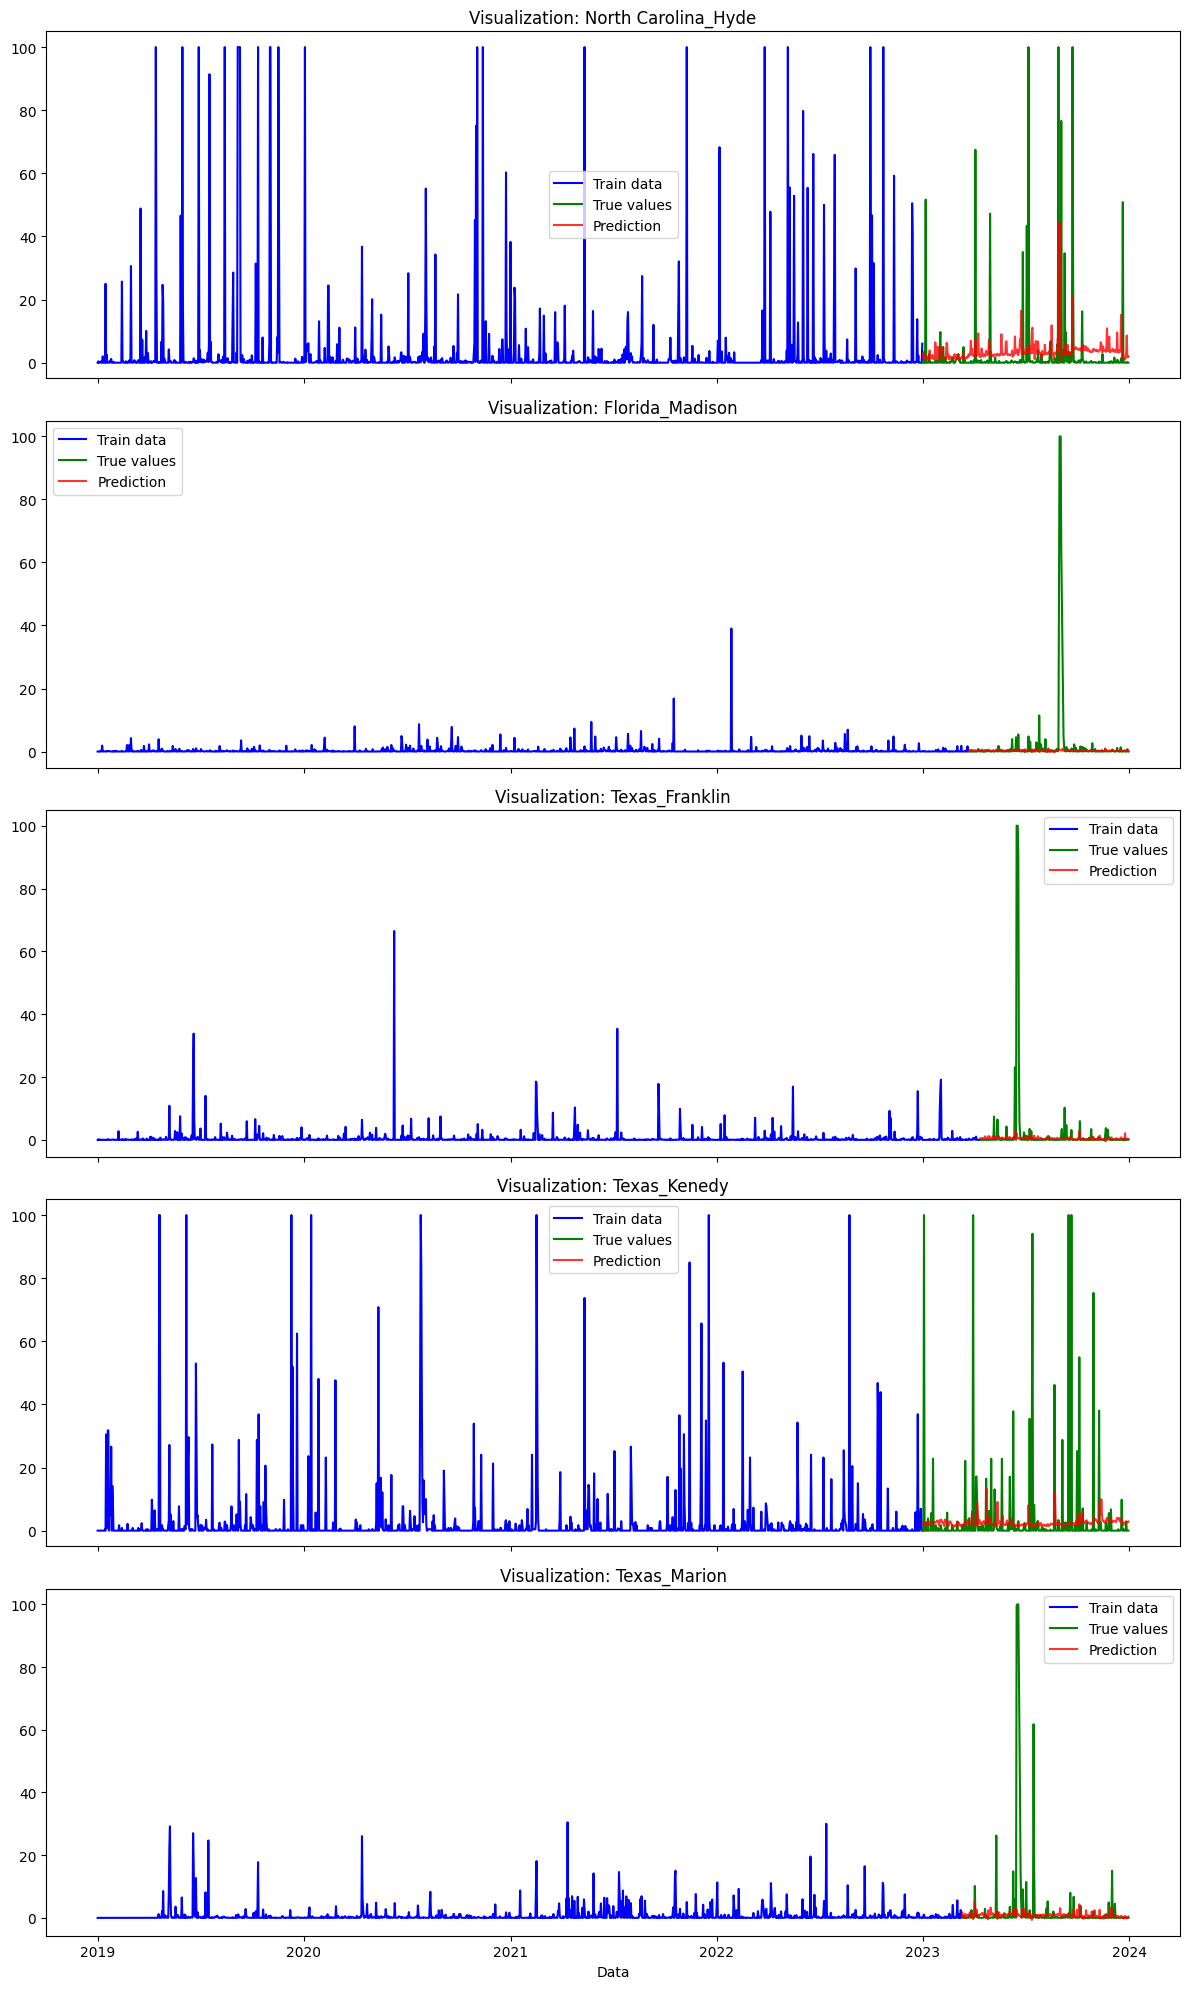

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 20), sharex=True)
fig.subplots_adjust(hspace=0.4)

for ax, county in zip(axes, counties_to_visualise):

    row = dict_copy[county[0]]
    train = row[0]
    test = row[1]
    forecast = row[3]

    train = train[~train.index.duplicated()]
    test = test[~test.index.duplicated()]
        
    ax.plot(train.index, train['PercentCustomersOut'], label='Train data', color='blue')
    ax.plot(test.index, test['PercentCustomersOut'], label='True values', color='green')
    ax.plot(test.index, forecast, label='Prediction', color='red', alpha=0.8)
    ax.set_title(f'Visualization: {county[0]}')
    #ax.set_ylim(0, maxlim)
    ax.legend()

    plt.xlabel("Data")
plt.tight_layout()
plt.show()

The key takeaway is that we cannot directly compare the RMSE metrics across different counties. Counties that experience frequent or major power outages tend to have much higher RMSE values because models struggle to accurately predict these large-scale events. Conversely, when a model shows a low RMSE, it often indicates that there were no major power outages between 2019 and 2024, making the prediction task much easier. In the interpretability section, however, we will still compare models with both high and low RMSE scores to better understand how they perform, why they produce certain results, and which features are the most influential in their predictions.

### TabNet

In [37]:
event_names = ['Astronomical Low Tide', 'Extreme Cold/Wind Chill', 'Flood','Winter Weather', 
               'Wildfire', 'Heavy Rain', 'Cold/Wind Chill', 'Dense Fog', 'Frost/Freeze', 'Strong Wind',
               'Lake-Effect Snow', 'Funnel Cloud', 'Flash Flood', 'Heavy Snow', 'Ice Storm', 
               'Thunderstorm Wind', 'Avalanche', 'Excessive Heat', 'Coastal Flood', 'Storm Surge/Tide', 
               'Sleet', 'Debris Flow', 'Winter Storm', 'Tropical Storm', 'Dust Storm', 'Drought', 
               'Blizzard', 'Lightning', 'Tornado', 'Hail', 'Rip Current', 'Heat', 'Freezing Fog', 
               'High Surf', 'High Wind']

In [38]:
df.shape

(8323937, 57)

Due to the high computational demands of TabNet, we had to limit both the dataset size and adjust the network parameters. We are using only the rows that we previously identified as "trustworthy" during the feature engineering stage, and we are selecting weather event columns that are expected to contribute the most valuable information.

In [39]:
df = df[df['ValidDataFlag'] == 1]
df.shape

(3240255, 57)

In [53]:
df['Year'].value_counts()
df = df[~df['Year'].isin([2015, 2016, 2017])]
df.shape

(2701153, 57)

In [49]:
zero_percentages = {}

for col in event_names:
    if col in df.columns:
        zero_count = (df[col] == 0).sum()
        total_count = len(df)
        zero_percentage = (zero_count / total_count) * 100
        zero_percentages[col] = zero_percentage

zero_percentages_df = pd.DataFrame.from_dict(zero_percentages, orient='index', columns=['%_zero'])
zero_percentages_df = zero_percentages_df.sort_values('%_zero', ascending=False)

display(zero_percentages_df)

,%_zero
High Surf,99.999593
Avalanche,99.999297
Freezing Fog,99.996557
Dust Storm,99.996298
Rip Current,99.995113
Storm Surge/Tide,99.993632
Sleet,99.987709
Astronomical Low Tide,99.987413
Lake-Effect Snow,99.978750
Debris Flow,99.978046


In [50]:
selected_events_name = [
    col for col, perc in zero_percentages.items() if perc < 99.8
]

print(selected_events_name)

['Flood', 'Winter Weather', 'Heavy Rain', 'Strong Wind', 'Flash Flood', 'Heavy Snow', 'Thunderstorm Wind', 'Excessive Heat', 'Winter Storm', 'Drought', 'Tornado', 'Hail', 'Heat', 'High Wind']


In [51]:
target = 'CustomersOut'

numeric_features = ['Tmin', 'Tmax', 'Tavg', 'Ppt', 'Lat', 'Lng']
categorical_features = ['Season', 'Region', 'Division', 'Month', 'StateName', 'CountyName']
event_features = [col for col in df.columns if col in selected_events_name]

X = df[numeric_features + categorical_features + event_features]
y = df[target]

In [52]:
X.shape, y.shape

((2701153, 26), (2701153,))

In [54]:
X_encoded = X.copy()
for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))


X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

In [ ]:
model_TabNet = TabNetRegressor(
    n_d=16,            
    n_a=16,
    n_steps=3,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":50, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

In [58]:
model_TabNet.fit(
    X_train=X_train.values,
    y_train=y_train.values.reshape(-1,1),
    eval_set=[(X_test.values, y_test.values.reshape(-1,1))],
    eval_metric=["rmse"],
    max_epochs=10,
    patience=4,
    batch_size=4096,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 3460273.93356| val_0_rmse: 1954.44042|  0:05:42s
epoch 1  | loss: 3445467.56533| val_0_rmse: 1950.2747|  0:15:46s
epoch 2  | loss: 3447512.20995| val_0_rmse: 1950.97798|  0:25:46s
epoch 3  | loss: 3433010.06952| val_0_rmse: 1947.5803|  0:35:15s
epoch 4  | loss: 3416002.92128| val_0_rmse: 1935.06165|  0:44:11s
epoch 5  | loss: 3392685.07911| val_0_rmse: 1921.98469|  0:53:11s
epoch 6  | loss: 3376295.85399| val_0_rmse: 1932.97782|  1:02:50s
epoch 7  | loss: 3355619.75473| val_0_rmse: 1922.84166|  1:13:28s
epoch 8  | loss: 3345976.31067| val_0_rmse: 1920.99402|  1:24:14s
epoch 9  | loss: 3335282.37767| val_0_rmse: 1917.46909|  1:34:50s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_0_rmse = 1917.46909


In [59]:
model_TabNet.save_model('../models/tabnet_model')

Successfully saved model at ../models/tabnet_model.zip


'../models/tabnet_model.zip'

In [60]:
y_pred = model_TabNet.predict(X_test.values).flatten()

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

MSE: 3676687.7208
RMSE: 1917.4691
R²: 0.0431


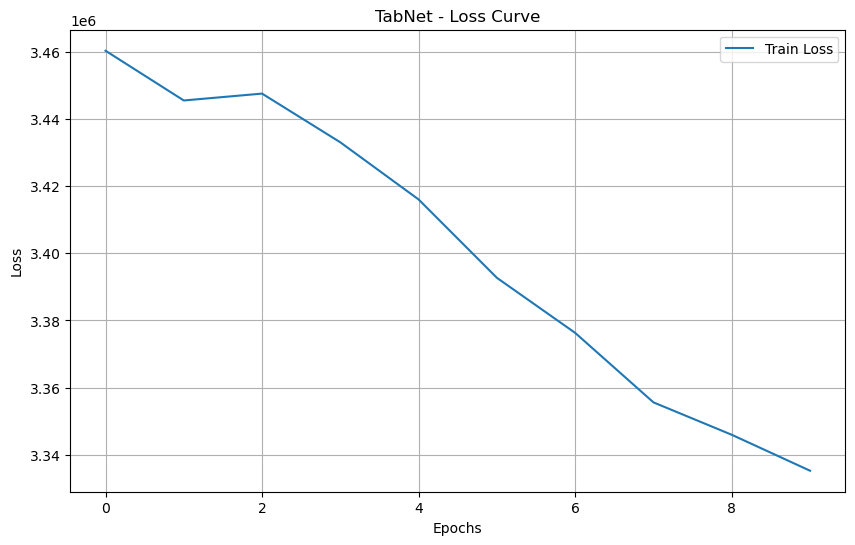

In [89]:
train_loss = model_TabNet.history['loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('TabNet - Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


Longer training

We will attempt to train the TabNet model again. Although the previous training did not yield the best results, we observed a very promising decrease in both loss and RMSE. We assume that a longer training process may help us achieve a better outcome. We are adjusting the training duration and diversifying the model architecture (while, of course, taking into account our computational limitations).

In [79]:
sample_frac = 0.1

sample_idx = np.random.choice(len(X_train), int(len(X_train) * sample_frac), replace=False)
X_sample = X_train.iloc[sample_idx]
y_sample = y_train.iloc[sample_idx]

X_train_small, X_val_small, y_train_small, y_val_small = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

In [83]:
param_grid = {
    'n_d': [16, 32],
    'n_a': [16, 32],
    'n_steps': [3, 5, 7],
    'gamma': [1.0, 1.5]
}

grid = list(product(*param_grid.values()))

In [81]:
def train_and_evaluate(X_train, y_train, X_val, y_val, params):
    model = TabNetRegressor(
        n_d=params['n_d'],
        n_a=params['n_a'],
        n_steps=params['n_steps'],
        gamma=params['gamma'],
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        verbose=1
    )
    model.fit(
        X_train=X_train.values,
        y_train=y_train.values.reshape(-1,1),
        eval_set=[(X_val.values, y_val.values.reshape(-1,1))],
        eval_metric=["rmse"],
        max_epochs=10,
        patience=3,
        batch_size=4096,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )
    preds = model.predict(X_val.values)
    rmse = mean_squared_error(y_val.values, preds, squared=False)
    return rmse

In [84]:
best_rmse = float('inf')
best_params = None

for values in grid:
    params = dict(zip(param_grid.keys(), values))
    print(f"Testing params: {params}")
    rmse = train_and_evaluate(X_train_small, y_train_small, X_val_small, y_val_small, params)
    print(f"RMSE: {rmse:.4f}")
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

print("\nBest parameters found:")
print(best_params)
print(f"Best RMSE: {best_rmse:.4f}")

Testing params: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.0}
epoch 0  | loss: 5472017.01989| val_0_rmse: 1581.56013|  0:00:40s
epoch 1  | loss: 5459390.40923| val_0_rmse: 1578.76356|  0:01:20s
epoch 2  | loss: 5450004.98245| val_0_rmse: 1579.36811|  0:01:56s
epoch 3  | loss: 5451716.98474| val_0_rmse: 1579.21782|  0:02:41s
epoch 4  | loss: 5449016.93197| val_0_rmse: 1578.61006|  0:03:27s
epoch 5  | loss: 5445539.40371| val_0_rmse: 1578.96193|  0:04:10s
epoch 6  | loss: 5443686.91298| val_0_rmse: 1577.58561|  0:04:54s
epoch 7  | loss: 5443509.16332| val_0_rmse: 1577.62899|  0:05:25s
epoch 8  | loss: 5440775.93659| val_0_rmse: 1578.31661|  0:05:53s
epoch 9  | loss: 5441087.69912| val_0_rmse: 1577.92144|  0:06:32s

Early stopping occurred at epoch 9 with best_epoch = 6 and best_val_0_rmse = 1577.58561
RMSE: 1577.5856
Testing params: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5}
epoch 0  | loss: 5472048.17123| val_0_rmse: 1581.83487|  0:00:32s
epoch 1  | loss: 5457123.39279| val

In [86]:
model_TabNet_v2 = TabNetRegressor(
    n_d=32,            
    n_a=16,
    n_steps=3,
    gamma=1.0,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":50, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

In [87]:
model_TabNet_v2.fit(
    X_train=X_train.values,
    y_train=y_train.values.reshape(-1,1),
    eval_set=[(X_train.values, y_train.values.reshape(-1,1)), 
     (X_test.values, y_test.values.reshape(-1,1))],
    eval_metric=["rmse"],
    max_epochs=100,
    patience=10,
    batch_size=4096,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 3457134.58037| val_0_rmse: 1857.26878| val_1_rmse: 1954.11536|  0:08:07s
epoch 1  | loss: 3447152.21128| val_0_rmse: 1853.31924| val_1_rmse: 1951.50246|  0:16:20s
epoch 2  | loss: 3438057.87929| val_0_rmse: 1849.97826| val_1_rmse: 1949.61545|  0:24:53s
epoch 3  | loss: 3434242.24095| val_0_rmse: 1851.74996| val_1_rmse: 1951.19503|  0:31:47s
epoch 4  | loss: 3427520.29119| val_0_rmse: 1843.51151| val_1_rmse: 1944.33749|  0:38:41s
epoch 5  | loss: 3429580.06117| val_0_rmse: 1851.02653| val_1_rmse: 1949.44956|  0:45:29s
epoch 6  | loss: 3428040.339| val_0_rmse: 1843.54925| val_1_rmse: 1943.58258|  0:52:17s
epoch 7  | loss: 3416243.91239| val_0_rmse: 1844.91138| val_1_rmse: 1945.73315|  0:59:05s
epoch 8  | loss: 3415560.75856| val_0_rmse: 1842.79327| val_1_rmse: 1943.17584|  1:05:49s
epoch 9  | loss: 3418547.12863| val_0_rmse: 1842.08184| val_1_rmse: 1944.80513|  1:17:06s
epoch 10 | loss: 3413026.7347| val_0_rmse: 1840.89688| val_1_rmse: 1940.56171|  1:25:43s
epoch 11 | lo

In [88]:
model_TabNet_v2.save_model('../models/tabnet_model_v2')

Successfully saved model at ../models/tabnet_model_v2.zip


'../models/tabnet_model_v2.zip'

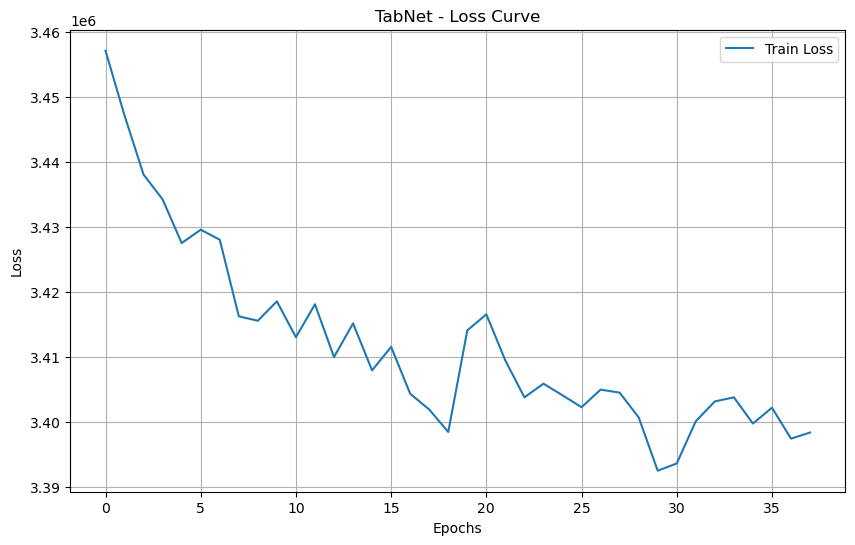

In [93]:
train_loss = model_TabNet_v2.history['loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('TabNet - Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

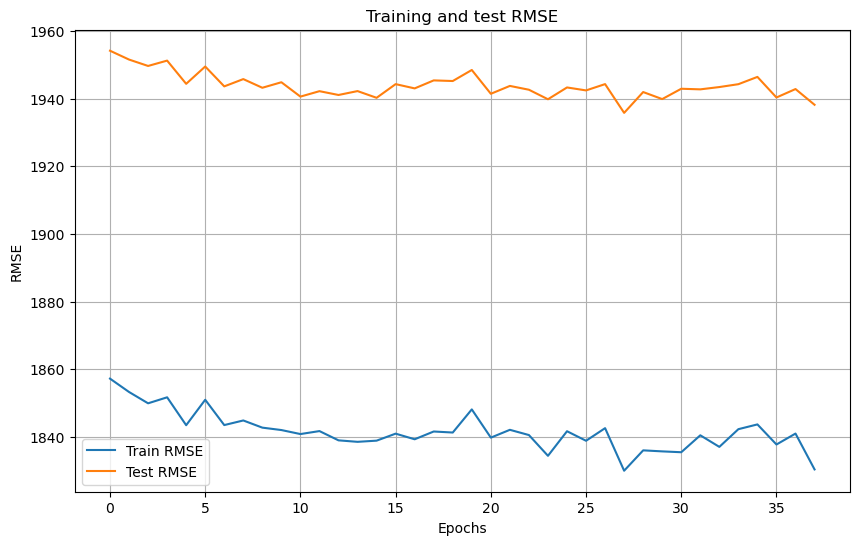

In [94]:
train_rmse = model_TabNet_v2.history['val_0_rmse']
test_rmse = model_TabNet_v2.history['val_1_rmse']

plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(test_rmse, label='Test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training and test RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [99]:
y_pred_train = model_TabNet_v2.predict(X_train.values).flatten()
y_pred_test = model_TabNet_v2.predict(X_test.values).flatten()

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f'RMSE on train: {train_rmse[-1]:6f}')
print(f'RMSE on test: {test_rmse[-1]:6f}')

print(f'R^2 on train: {r2_train:6f}')
print(f'R^2 on test: {r2_test:6f}')

RMSE on train: 1830.451422
RMSE on test: 1938.148024
R^2 on train: 0.035120
R^2 on test: 0.024777


Our assumptions have been confirmed — it is particularly noticeable during the initial phases of training that the loss consistently decreases after applying a more complex architecture and extending the training duration. However, the model still achieves relatively high RMSE values.

It is important to note that these results are aggregated across the entire country. In the following sections, we will take a closer look at the performance across individual states, which will reveal that there are counties where the model performs significantly better. We will further analyze these states to investigate why the model achieves more favorable results in those specific areas.

### TabNet for State-Specific

In [100]:
df = pd.read_csv('../data/modelingData/modelingDataFrame.csv')

In [104]:
df_wyoming = df[df['StateName'] == 'Wyoming']

In [106]:
event_names = ['Astronomical Low Tide', 'Extreme Cold/Wind Chill', 'Flood','Winter Weather', 
               'Wildfire', 'Heavy Rain', 'Cold/Wind Chill', 'Dense Fog', 'Frost/Freeze', 'Strong Wind',
               'Lake-Effect Snow', 'Funnel Cloud', 'Flash Flood', 'Heavy Snow', 'Ice Storm', 
               'Thunderstorm Wind', 'Avalanche', 'Excessive Heat', 'Coastal Flood', 'Storm Surge/Tide', 
               'Sleet', 'Debris Flow', 'Winter Storm', 'Tropical Storm', 'Dust Storm', 'Drought', 
               'Blizzard', 'Lightning', 'Tornado', 'Hail', 'Rip Current', 'Heat', 'Freezing Fog', 
               'High Surf', 'High Wind']

In [ ]:
target = 'CustomersOut'

numeric_features = ['Tmin', 'Tmax', 'Tavg', 'Ppt', 'Lat', 'Lng']
categorical_features = ['Season', 'Region', 'Division', 'Month', 'StateName', 'CountyName']
event_features = [col for col in df_wyoming.columns if col in selected_events_name]

X = df_wyoming[numeric_features + categorical_features + event_features]
y = df_wyoming[target]

X_encoded = X.copy()
for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

In [145]:
Q3 = np.percentile(y, 90)
Q1 = np.percentile(y, 10)
IQR = Q3 - Q1
upper_bound = Q3 + 1.0 * IQR
mask = (y <= upper_bound)

y_no_outliers = y[mask]
X_no_outliers = X_encoded[mask]

print(f"Before: {len(y)}")
print(f"After: {len(y_no_outliers)}")


Before: 45482
After: 42610


In [142]:
X_train_wyoming, X_test_wyoming, y_train_wyoming, y_test_wyoming = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.2, random_state=42
)

In [143]:
model_TabNet_wyoming = TabNetRegressor(
    n_d=64,            
    n_a=64,
    n_steps=10,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.AdamW,    
    optimizer_params=dict(lr=1e-3),
    scheduler_params={"step_size":50, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

In [144]:
model_TabNet_wyoming.fit(
    X_train=X_train_wyoming.values,
    y_train=y_train_wyoming.values.reshape(-1,1),
    eval_set=[(X_train_wyoming.values, y_train_wyoming.values.reshape(-1,1)), 
     (X_test_wyoming.values, y_test_wyoming.values.reshape(-1,1))],
    eval_metric=["rmse"],
    max_epochs=100,
    patience=10,
    batch_size=2048,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=True
)

epoch 0  | loss: 66.08775| val_0_rmse: 9.65255 | val_1_rmse: 9.90274 |  0:00:21s
epoch 1  | loss: 44.90058| val_0_rmse: 8.20171 | val_1_rmse: 8.2308  |  0:00:49s
epoch 2  | loss: 36.77623| val_0_rmse: 6.36563 | val_1_rmse: 6.28643 |  0:01:24s
epoch 3  | loss: 34.17688| val_0_rmse: 5.90751 | val_1_rmse: 5.83339 |  0:02:12s
epoch 4  | loss: 32.74263| val_0_rmse: 5.95629 | val_1_rmse: 6.18011 |  0:03:01s
epoch 5  | loss: 31.84185| val_0_rmse: 5.78111 | val_1_rmse: 5.8203  |  0:03:48s
epoch 6  | loss: 30.98863| val_0_rmse: 5.59607 | val_1_rmse: 5.44787 |  0:04:36s
epoch 7  | loss: 30.54298| val_0_rmse: 5.44853 | val_1_rmse: 5.27292 |  0:05:24s
epoch 8  | loss: 30.24294| val_0_rmse: 5.42054 | val_1_rmse: 5.33707 |  0:06:17s
epoch 9  | loss: 29.56377| val_0_rmse: 5.37058 | val_1_rmse: 5.24859 |  0:07:05s
epoch 10 | loss: 29.29466| val_0_rmse: 5.34635 | val_1_rmse: 5.24715 |  0:07:50s
epoch 11 | loss: 29.48942| val_0_rmse: 5.35611 | val_1_rmse: 5.25163 |  0:08:33s
epoch 12 | loss: 29.34352| v

In [150]:
y_pred_wyoming = model_TabNet_wyoming.predict(X_train_wyoming.values)

rmse = np.sqrt(mean_squared_error(y_train_wyoming, y_pred_wyoming))
mae = mean_absolute_error(y_train_wyoming, y_pred_wyoming)
r2 = r2_score(y_train_wyoming, y_pred_wyoming)

results_df = pd.DataFrame({
    'y_train_wyoming': y_train_wyoming.values.flatten(),
    'y_pred_wyoming': y_pred_wyoming.flatten()
})

# print(results_df.head())
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 5.2818
MAE: 3.1500
R²: 0.0076


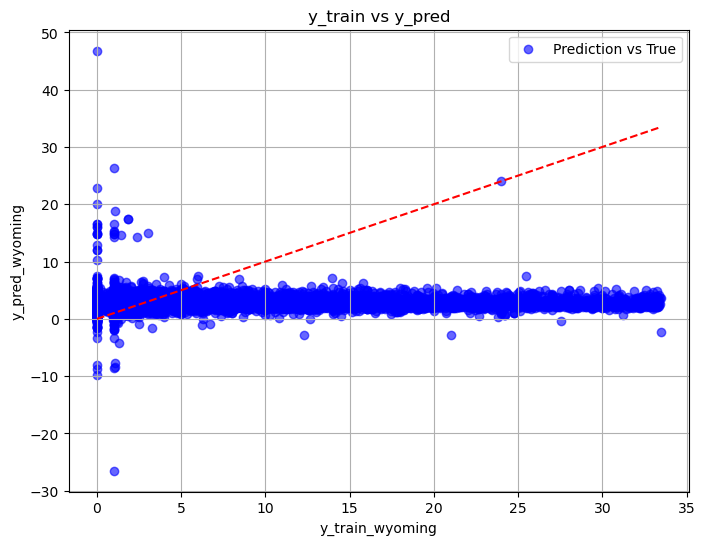

In [152]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train_wyoming, y_pred_wyoming, alpha=0.6, color='blue', label='Prediction vs True')
plt.plot([min(y_train_wyoming), max(y_train_wyoming)], [min(y_train_wyoming), max(y_train_wyoming)], color='red', linestyle='--')
plt.title('y_train vs y_pred')
plt.xlabel('y_train_wyoming')
plt.ylabel('y_pred_wyoming')
plt.legend()
plt.grid(True)
plt.show()

It is noticeable that after removing the outliers, the overall model parameters improved. However, the model significantly underestimates the results and rarely predicts values above 10. Let's see how the situation changes if we switch the target to CustomersOutEstimate (i.e., the column filled with our predictions).

In [153]:
target = 'CustomersOutEstimate'
y = df_wyoming[target]

In [164]:
Q3 = np.percentile(y, 99)
Q1 = np.percentile(y, 0)
IQR = Q3 - Q1
upper_bound = Q3 + 1.0 * IQR
mask = (y <= upper_bound)

y_no_outliers = y[mask]
X_no_outliers = X_encoded[mask]

print(f"Before: {len(y)}")
print(f"After: {len(y_no_outliers)}")


Before: 45482
After: 45315


In [165]:
X_train_wyoming, X_test_wyoming, y_train_wyoming, y_test_wyoming = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.2, random_state=42
)

In [166]:
model_TabNet_wyoming_v2 = TabNetRegressor(
    n_d=64,            
    n_a=64,
    n_steps=10,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.AdamW,    
    optimizer_params=dict(lr=1e-3),
    scheduler_params={"step_size":50, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

In [167]:
model_TabNet_wyoming_v2.fit(
    X_train=X_train_wyoming.values,
    y_train=y_train_wyoming.values.reshape(-1,1),
    eval_set=[(X_train_wyoming.values, y_train_wyoming.values.reshape(-1,1)), 
     (X_test_wyoming.values, y_test_wyoming.values.reshape(-1,1))],
    eval_metric=["rmse"],
    max_epochs=100,
    patience=10,
    batch_size=2048,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=True
)

epoch 0  | loss: 7784.82695| val_0_rmse: 88.07506| val_1_rmse: 83.64131|  0:00:34s
epoch 1  | loss: 7641.67722| val_0_rmse: 86.66261| val_1_rmse: 82.28245|  0:01:17s
epoch 2  | loss: 7449.35196| val_0_rmse: 86.02856| val_1_rmse: 81.44336|  0:01:58s
epoch 3  | loss: 7428.69603| val_0_rmse: 85.18404| val_1_rmse: 80.57013|  0:02:34s
epoch 4  | loss: 7265.75118| val_0_rmse: 84.87162| val_1_rmse: 80.33918|  0:03:07s
epoch 5  | loss: 7171.44247| val_0_rmse: 84.52785| val_1_rmse: 80.04478|  0:03:36s
epoch 6  | loss: 7118.54058| val_0_rmse: 84.31534| val_1_rmse: 79.7011 |  0:04:03s
epoch 7  | loss: 6986.23165| val_0_rmse: 83.82144| val_1_rmse: 79.39158|  0:04:36s
epoch 8  | loss: 6916.13982| val_0_rmse: 83.89018| val_1_rmse: 79.33238|  0:05:09s
epoch 9  | loss: 7071.23969| val_0_rmse: 83.69383| val_1_rmse: 79.24481|  0:05:54s
epoch 10 | loss: 6885.25497| val_0_rmse: 83.6449 | val_1_rmse: 79.13445|  0:06:35s
epoch 11 | loss: 6921.39114| val_0_rmse: 83.57223| val_1_rmse: 79.10818|  0:07:05s
epoc

In [168]:
y_pred_wyoming = model_TabNet_wyoming_v2.predict(X_train_wyoming.values)

rmse = np.sqrt(mean_squared_error(y_train_wyoming, y_pred_wyoming))
mae = mean_absolute_error(y_train_wyoming, y_pred_wyoming)
r2 = r2_score(y_train_wyoming, y_pred_wyoming)

results_df = pd.DataFrame({
    'y_train_wyoming': y_train_wyoming.values.flatten(),
    'y_pred_wyoming': y_pred_wyoming.flatten()
})

print(results_df.head())
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

   y_train_wyoming  y_pred_wyoming
0         5.166667       17.158096
1         0.543630       15.634475
2        12.674334       27.280848
3        15.515848       27.628262
4         1.333333       21.789179
RMSE: 82.6754
MAE: 34.3257
R²: 0.0057


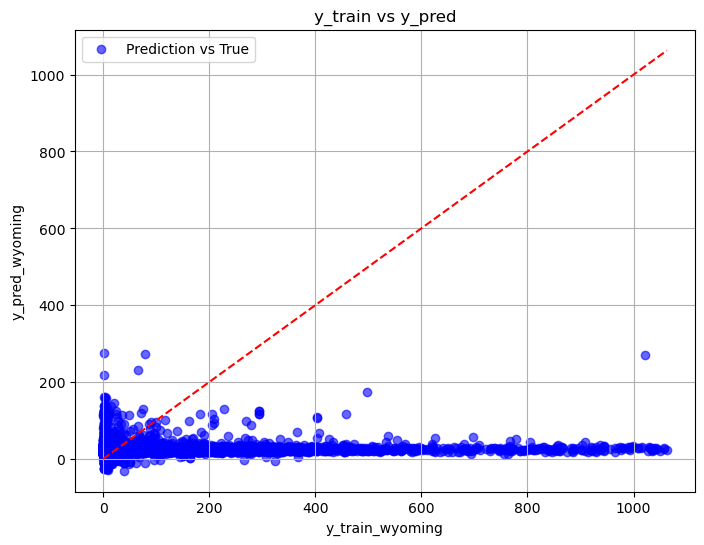

In [169]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train_wyoming, y_pred_wyoming, alpha=0.6, color='blue', label='Prediction vs True')
plt.plot([min(y_train_wyoming), max(y_train_wyoming)], [min(y_train_wyoming), max(y_train_wyoming)], color='red', linestyle='--')
plt.title('y_train vs y_pred')
plt.xlabel('y_train_wyoming')
plt.ylabel('y_pred_wyoming')
plt.legend()
plt.grid(True)
plt.show()

The model tends to significantly underestimate values even after changing the target to the CustomersOutEstimate column. It is likely that not all events are recorded in the dataset related to catastrophic events, or that the causes of power outages are not strictly correlated with weather-related incidents.

In [170]:
df_folrida = df[df['StateName'] == 'Florida']

In [173]:
target = 'CustomersOut'

numeric_features = ['Tmin', 'Tmax', 'Tavg', 'Ppt', 'Lat', 'Lng']
categorical_features = ['Season', 'Region', 'Division', 'Month', 'CountyName']
event_features = [col for col in df_folrida.columns if col in event_names]

X = df_folrida[numeric_features + categorical_features + event_features]
y = df_folrida[target]

X_encoded = X.copy()
for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

In [174]:
Q3 = np.percentile(y, 90)
Q1 = np.percentile(y, 10)
IQR = Q3 - Q1
upper_bound = Q3 + 1.0 * IQR
mask = (y <= upper_bound)

y_no_outliers = y[mask]
X_no_outliers = X_encoded[mask]

print(f"Before: {len(y)}")
print(f"After: {len(y_no_outliers)}")

Before: 228359
After: 218442


In [175]:
X_train_florida, X_test_florida, y_train_florida, y_test_florida = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.2, random_state=42
)

In [176]:
model_TabNet_florida = TabNetRegressor(
    n_d=64,            
    n_a=64,
    n_steps=10,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.AdamW,    
    optimizer_params=dict(lr=1e-3),
    scheduler_params={"step_size":50, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

In [177]:
model_TabNet_florida.fit(
    X_train=X_train_florida.values,
    y_train=y_train_florida.values.reshape(-1,1),
    eval_set=[(X_train_florida.values, y_train_florida.values.reshape(-1,1)), 
     (X_test_florida.values, y_test_florida.values.reshape(-1,1))],
    eval_metric=["rmse"],
    max_epochs=100,
    patience=10,
    batch_size=2048,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=True
)

epoch 0  | loss: 3330.54324| val_0_rmse: 54.53591| val_1_rmse: 54.73665|  0:02:50s
epoch 1  | loss: 3056.39189| val_0_rmse: 55.40392| val_1_rmse: 55.55145|  0:05:51s
epoch 2  | loss: 2889.13402| val_0_rmse: 55.17335| val_1_rmse: 55.34093|  0:09:19s
epoch 3  | loss: 2765.69392| val_0_rmse: 53.58887| val_1_rmse: 53.73452|  0:13:21s
epoch 4  | loss: 2674.57049| val_0_rmse: 53.20912| val_1_rmse: 53.44238|  0:16:20s
epoch 5  | loss: 2629.82648| val_0_rmse: 52.82434| val_1_rmse: 52.97816|  0:18:57s
epoch 6  | loss: 2557.22742| val_0_rmse: 51.70224| val_1_rmse: 51.80631|  0:21:20s
epoch 7  | loss: 2529.50451| val_0_rmse: 51.09394| val_1_rmse: 51.20444|  0:23:30s
epoch 8  | loss: 2530.52263| val_0_rmse: 51.09485| val_1_rmse: 51.26196|  0:25:49s
epoch 9  | loss: 2522.51878| val_0_rmse: 51.15961| val_1_rmse: 51.27517|  0:28:04s
epoch 10 | loss: 2504.87254| val_0_rmse: 50.77402| val_1_rmse: 50.91463|  0:30:16s
epoch 11 | loss: 2497.17446| val_0_rmse: 51.44342| val_1_rmse: 51.44876|  0:32:25s
epoc

In [178]:
y_pred_florida = model_TabNet_florida.predict(X_train_florida.values)

rmse = np.sqrt(mean_squared_error(y_train_florida, y_pred_florida))
mae = mean_absolute_error(y_train_florida, y_pred_florida)
r2 = r2_score(y_train_florida, y_pred_florida)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 50.2468
MAE: 32.4147
R²: 0.0484


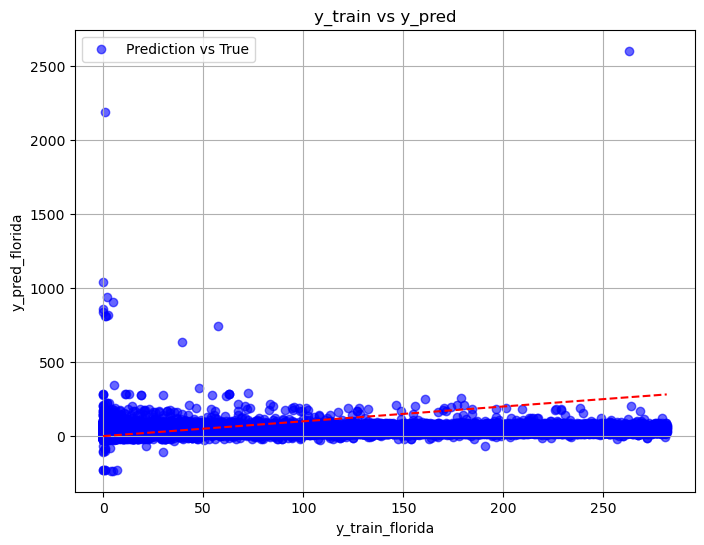

In [180]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train_florida, y_pred_florida, alpha=0.6, color='blue', label='Prediction vs True')
plt.plot([min(y_train_florida), max(y_train_florida)], [min(y_train_florida), max(y_train_florida)], color='red', linestyle='--')
plt.title('y_train vs y_pred')
plt.xlabel('y_train_florida')
plt.ylabel('y_pred_florida')
plt.legend()
plt.grid(True)
plt.show()

In [182]:
model_TabNet_florida.save_model('../models/model_TabNet_florida')

Successfully saved model at ../models/model_TabNet_florida.zip


'../models/model_TabNet_florida.zip'

While we did not observe any improvement for the state of Wyoming (which was already the best predicted by the general model), we see a striking improvement for the state of Florida, which was previously the worst predicted. Now, with a model dedicated solely to Florida, the performance is even better than that for Wyoming. This leads to a simple conclusion: the model struggles to learn such highly diverse patterns when trained on all data together, but it starts to perform slightly better when we narrow the data down to smaller, more homogeneous subsets.